In [31]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin
from tqdm import tqdm

# Load data

In [32]:
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
alpha = data[:,4]
alpha_opt = data[:,5]
beta = data[:,6]
gamma = data[:,7]

# Take only the data where rho_min_x is smaller than 0.8, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x < 0.7) & (rho_min_x > 0.4) & (rho_max_x > 1.5) & (rho_max_x < 2.5))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
alpha = alpha[indices]
alpha_opt = alpha_opt[indices]
beta = beta[indices]
gamma = gamma[indices]





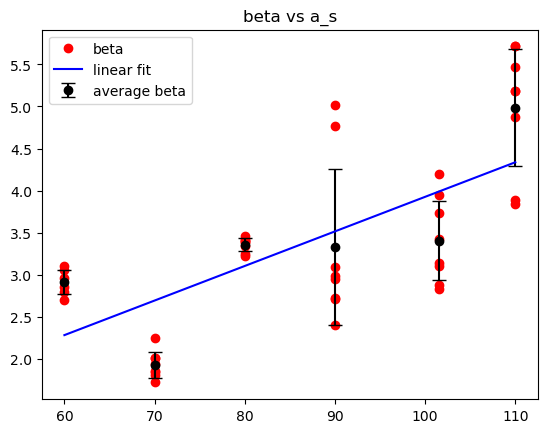

In [33]:
# Plot beta vs a_s
plt.plot(a_s, beta, 'o', label='beta', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average beta', capsize=5, color='black')
# Make a linear fit of the average beta vs a_s
def func_beta(x, a, b):
    return a*x + b
popt_beta, pcov = curve_fit(func_beta, a_s_unique, average)
plt.plot(a_s_unique, func_beta(a_s_unique, *popt_beta), label='linear fit', color='blue')
plt.title("beta vs a_s")
plt.legend(loc='best')

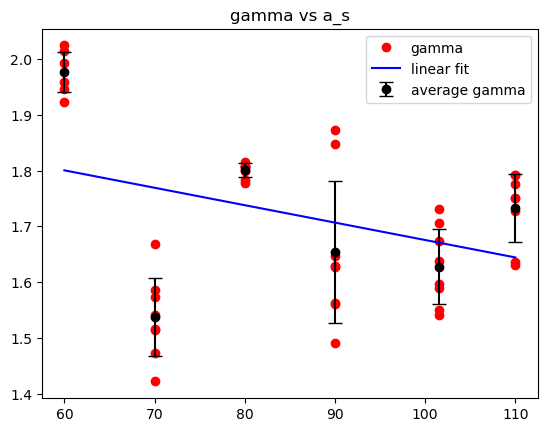

In [34]:
# Plot gamma vs a_s
plt.plot(a_s, gamma, 'o', label='gamma', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(gamma[a_s==a_s_unique[i]])
    std[i] = np.std(gamma[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average gamma', capsize=5, color='black')
# Make a linear fit of the average gamma vs a_s
def func_gamma(x, a, b):
    return a*x + b
popt_gamma, pcov = curve_fit(func_gamma, a_s_unique, average)
plt.plot(a_s_unique, func_gamma(a_s_unique, *popt_gamma), label='linear fit', color='blue')
plt.title("gamma vs a_s")
plt.legend(loc='best')

# Estimate $n_c$ for each $a_s$ value, using fits


In [35]:
from estimate_nc.estimate_nc import estimate_nc, en_per_particle

In [36]:
a_s = np.linspace(60, 110, 50)
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# for each a_s, find the best possible fit for n_c, using the fits func_beta and func_gamma
n_c_best_possible_fit = np.zeros(len(a_s))
for i in tqdm(range(len(a_s))):
    alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
    n_c_best_possible_fit[i] = estimate_nc(alpha,func_beta(a_s[i], *popt_beta), func_gamma(a_s[i], *popt_gamma), based_on="size")[0]


  0%|          | 0/50 [00:00<?, ?it/s]

nparticles: 285000.0, sr_local_min: [15.72344689 15.32284569 14.92224449 14.52164329 14.12104208 13.72044088
 13.31983968 12.91923848 12.51863727 12.11803607 11.71743487 11.31683367
 10.91623246 10.51563126 10.11503006], sz_local_min: [ 613.29579158  641.350501    673.41302605  709.48336673  745.55370741
  789.63967936  833.7256513   885.82725451  937.92885772 1002.05390782
 1066.17895792 1142.32745491 1226.49158317 1318.67134269 1426.88236473]
nparticles: 270750.0, sr_local_min: [15.32284569 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968
 12.91923848 12.51863727 12.11803607 11.71743487 11.31683367 10.91623246
 10.51563126 10.11503006], sz_local_min: [ 613.29579158  641.350501    673.41302605  709.48336673  749.56152305
  793.64749499  841.74128257  893.84288577  949.95230461 1014.07735471
 1086.21803607 1166.3743487  1254.54629259 1354.74168337]
nparticles: 257212.5, sr_local_min: [15.32284569 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968
 12.91923848 12.518

  2%|▏         | 1/50 [00:04<03:26,  4.22s/it]

nparticles: 310.51627197176236, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  28.15470942 1507.03867735]
nparticles: 294.99045837317425, sr_local_min: [  4.90721443   6.50961924 200.        ], sz_local_min: [  28.15470942   32.16252505 1547.11683367]
nparticles: 280.2409354545155, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  28.15470942 1587.19498998]
nparticles: 266.2288886817897, sr_local_min: [200.], sz_local_min: [1631.28096192]
nparticles: 285000.0, sr_local_min: [15.72344689 15.32284569 14.92224449 14.52164329 14.12104208 13.72044088
 13.31983968 12.91923848 12.51863727 12.11803607 11.71743487 11.31683367
 10.91623246 10.51563126], sz_local_min: [ 641.350501    669.40521042  705.4755511   741.54589178  781.6240481
  825.71002004  869.79599198  925.90541082  982.01482966 1046.13987976
 1118.28056112 1194.42905812 1282.601002   1382.79639279]
nparticles: 270750.0, sr_local_min: [16.1240481  15.72344689 15.32284569 14.92224449 14.52164329 14.12104208
 13

  4%|▍         | 2/50 [00:07<03:09,  3.96s/it]

nparticles: 381.23252212215976, sr_local_min: [  4.50661323 200.        ], sz_local_min: [  28.15470942 1390.81202405]
nparticles: 362.17089601605176, sr_local_min: [  4.50661323 200.        ], sz_local_min: [  28.15470942 1422.8745491 ]
nparticles: 344.0623512152492, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  28.15470942 1454.93707415]
nparticles: 326.85923365448673, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  28.15470942 1491.00741483]
nparticles: 310.51627197176236, sr_local_min: [  5.30781563   6.10901804 200.        ], sz_local_min: [  28.15470942   32.16252505 1527.07775551]
nparticles: 294.99045837317425, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  28.15470942 1567.15591182]
nparticles: 280.2409354545155, sr_local_min: [200.], sz_local_min: [1607.23406814]
nparticles: 285000.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.1180

  6%|▌         | 3/50 [00:11<03:03,  3.90s/it]

nparticles: 381.23252212215976, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  28.15470942 1406.84328657]
nparticles: 362.17089601605176, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  28.15470942 1438.90581162]
nparticles: 344.0623512152492, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  28.15470942 1474.9761523 ]
nparticles: 326.85923365448673, sr_local_min: [  5.30781563   5.70841683 200.        ], sz_local_min: [  28.15470942   32.16252505 1511.04649299]
nparticles: 310.51627197176236, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  28.15470942 1547.11683367]
nparticles: 294.99045837317425, sr_local_min: [200.], sz_local_min: [1587.19498998]
nparticles: 285000.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727 12.11803607
 11.71743487 11.31683367], sz_local_min: [ 637.34268537  665.39739479  697.45991984  733.53026052  769.6006012
  

  8%|▊         | 4/50 [00:15<02:59,  3.91s/it]

nparticles: 381.23252212215976, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1426.88236473]
nparticles: 362.17089601605176, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1458.94488978]
nparticles: 344.0623512152492, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  32.16252505 1495.01523046]
nparticles: 326.85923365448673, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  32.16252505 1531.08557114]
nparticles: 310.51627197176236, sr_local_min: [200.], sz_local_min: [1567.15591182]
nparticles: 285000.0, sr_local_min: [16.9252505  16.5246493  16.1240481  15.72344689 15.32284569 14.92224449
 14.52164329 14.12104208 13.72044088 13.31983968 12.91923848 12.51863727
 12.11803607], sz_local_min: [ 637.34268537  665.39739479  697.45991984  729.52244489  765.59278557
  805.67094188  845.7490982   893.84288577  941.93667335  998.04609218
 1058.16332665 1126.29619238 1198.43687375]
nparticles: 270750.0, sr_local_min: [16.1240

 10%|█         | 5/50 [00:19<02:53,  3.85s/it]

nparticles: 444.6508495374367, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  32.16252505 1354.74168337]
nparticles: 422.41830706056487, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1382.79639279]
nparticles: 401.29739170753663, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1414.85891784]
nparticles: 381.23252212215976, sr_local_min: [  5.70841683   8.11202405 200.        ], sz_local_min: [  32.16252505   40.17815631 1446.92144289]
nparticles: 362.17089601605176, sr_local_min: [  5.70841683   6.91022044 200.        ], sz_local_min: [  32.16252505   36.17034068 1478.98396794]
nparticles: 344.0623512152492, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  32.16252505 1511.04649299]
nparticles: 326.85923365448673, sr_local_min: [200.], sz_local_min: [1551.1246493]
nparticles: 285000.0, sr_local_min: [16.5246493  16.1240481  15.72344689 15.32284569 14.92224449 14.52164329
 14.12104208 13.72044088 13.31983968 12.91

 12%|█▏        | 6/50 [00:23<02:44,  3.74s/it]

nparticles: 518.6188651843555, sr_local_min: [  4.90721443 200.        ], sz_local_min: [  36.17034068 1294.6244489 ]
nparticles: 492.6879219251377, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  36.17034068 1322.67915832]
nparticles: 468.05352582888077, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1346.7260521 ]
nparticles: 444.6508495374367, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1374.78076152]
nparticles: 422.41830706056487, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  32.16252505 1402.83547094]
nparticles: 401.29739170753663, sr_local_min: [  5.70841683   6.10901804 200.        ], sz_local_min: [  32.16252505   36.17034068 1430.89018036]
nparticles: 381.23252212215976, sr_local_min: [  6.10901804   6.91022044 200.        ], sz_local_min: [  32.16252505   36.17034068 1462.95270541]
nparticles: 362.17089601605176, sr_local_min: [200.], sz_local_min: [1499.02304609]
nparticles: 285000.0, sr_local_m

 14%|█▍        | 7/50 [00:26<02:39,  3.70s/it]

nparticles: 492.6879219251377, sr_local_min: [  5.30781563 200.        ], sz_local_min: [  36.17034068 1338.71042084]
nparticles: 468.05352582888077, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  36.17034068 1366.76513026]
nparticles: 444.6508495374367, sr_local_min: [  5.70841683 200.        ], sz_local_min: [  36.17034068 1390.81202405]
nparticles: 422.41830706056487, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  36.17034068 1422.8745491 ]
nparticles: 401.29739170753663, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  36.17034068 1450.92925852]
nparticles: 381.23252212215976, sr_local_min: [200.], sz_local_min: [1482.99178357]
nparticles: 285000.0, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481  15.72344689 15.32284569
 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968], sz_local_min: [ 701.46773547  729.52244489  761.58496994  797.65531062  833.7256513
  877.81162325  921.89759519  969.99138277 1022.09298597 1082.21022

 16%|█▌        | 8/50 [00:30<02:33,  3.65s/it]

nparticles: 422.41830706056487, sr_local_min: [  6.50961924   8.11202405 200.        ], sz_local_min: [  36.17034068   40.17815631 1442.91362725]
nparticles: 401.29739170753663, sr_local_min: [200.], sz_local_min: [1470.96833667]
nparticles: 285000.0, sr_local_min: [17.72645291 17.3258517  16.9252505  16.5246493  16.1240481  15.72344689
 15.32284569 14.92224449 14.52164329 14.12104208 13.72044088], sz_local_min: [ 701.46773547  733.53026052  761.58496994  797.65531062  833.7256513
  873.80380762  917.88977956  965.98356713 1014.07735471 1070.18677355
 1134.31182365]
nparticles: 270750.0, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481  15.72344689 15.32284569
 14.92224449 14.52164329 14.12104208 13.72044088 13.31983968], sz_local_min: [ 697.45991984  729.52244489  761.58496994  793.64749499  833.7256513
  873.80380762  917.88977956  965.98356713 1018.08517034 1078.20240481
 1142.32745491]
nparticles: 257212.5, sr_local_min: [17.3258517  16.9252505  16.5246493  16.1240481 

 18%|█▊        | 9/50 [00:33<02:30,  3.66s/it]

nparticles: 468.05352582888077, sr_local_min: [  6.91022044   8.11202405 200.        ], sz_local_min: [  40.17815631   44.18597194 1402.83547094]
nparticles: 444.6508495374367, sr_local_min: [  7.71142285 200.        ], sz_local_min: [  40.17815631 1430.89018036]
nparticles: 422.41830706056487, sr_local_min: [200.], sz_local_min: [1462.95270541]
nparticles: 285000.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329 14.12104208], sz_local_min: [ 705.4755511   733.53026052  765.59278557  797.65531062  833.7256513
  873.80380762  913.88196393  961.9757515  1010.06953908 1066.17895792
 1122.28837675]
nparticles: 270750.0, sr_local_min: [17.72645291 17.3258517  16.9252505  16.5246493  16.1240481  15.72344689
 15.32284569 14.92224449 14.52164329 14.12104208 13.72044088], sz_local_min: [ 701.46773547  729.52244489  761.58496994  793.64749499  833.7256513
  873.80380762  913.88196393  961.9757515  1014.077354

 20%|██        | 10/50 [00:37<02:23,  3.60s/it]

nparticles: 518.6188651843555, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  40.17815631 1370.77294589]
nparticles: 492.6879219251377, sr_local_min: [  6.91022044   7.71142285 200.        ], sz_local_min: [  40.17815631   44.18597194 1394.81983968]
nparticles: 468.05352582888077, sr_local_min: [200.], sz_local_min: [1422.8745491]
nparticles: 285000.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329], sz_local_min: [ 741.54589178  769.6006012   801.66312625  837.73346693  873.80380762
  913.88196393  957.96793587 1006.06172345 1058.16332665 1114.27274549]
nparticles: 270750.0, sr_local_min: [18.12705411 17.72645291 17.3258517  16.9252505  16.5246493  16.1240481
 15.72344689 15.32284569 14.92224449 14.52164329 14.12104208], sz_local_min: [ 705.4755511   733.53026052  765.59278557  797.65531062  833.7256513
  873.80380762  913.88196393  957.96793587 1010.06953908 1062.17114228
 1122.288376

 22%|██▏       | 11/50 [00:40<02:17,  3.53s/it]

nparticles: 705.5156937500813, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  44.18597194 1258.55410822]
nparticles: 670.2399090625771, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  44.18597194 1274.58537074]
nparticles: 636.7279136094483, sr_local_min: [  6.10901804 200.        ], sz_local_min: [  44.18597194 1298.63226453]
nparticles: 604.8915179289758, sr_local_min: [  6.10901804   6.50961924 200.        ], sz_local_min: [  40.17815631   44.18597194 1318.67134269]
nparticles: 574.6469420325269, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  40.17815631 1338.71042084]
nparticles: 545.9145949309005, sr_local_min: [  6.50961924   6.91022044 200.        ], sz_local_min: [  40.17815631   44.18597194 1362.75731463]
nparticles: 518.6188651843555, sr_local_min: [  6.91022044   7.71142285 200.        ], sz_local_min: [  40.17815631   44.18597194 1390.81202405]
nparticles: 492.6879219251377, sr_local_min: [200.], sz_local_min: [1414.85891784]
nparticles

 24%|██▍       | 12/50 [00:44<02:13,  3.51s/it]

nparticles: 705.5156937500813, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  44.18597194 1274.58537074]
nparticles: 670.2399090625771, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  44.18597194 1294.6244489 ]
nparticles: 636.7279136094483, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  44.18597194 1314.66352705]
nparticles: 604.8915179289758, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  44.18597194 1338.71042084]
nparticles: 574.6469420325269, sr_local_min: [  7.31082164   9.31382766 200.        ], sz_local_min: [  44.18597194   52.20160321 1358.749499  ]
nparticles: 545.9145949309005, sr_local_min: [  7.71142285 200.        ], sz_local_min: [  44.18597194 1382.79639279]
nparticles: 518.6188651843555, sr_local_min: [200.], sz_local_min: [1410.8511022]
nparticles: 285000.0, sr_local_min: [18.52765531 18.12705411 17.72645291 17.3258517  16.9252505  16.5246493
 16.1240481  15.72344689 15.32284569], sz_local_min: [ 781.6240481   813.68

 26%|██▌       | 13/50 [00:47<02:09,  3.51s/it]

nparticles: 742.6480986842961, sr_local_min: [  6.50961924 200.        ], sz_local_min: [  48.19378758 1274.58537074]
nparticles: 705.5156937500813, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  48.19378758 1294.6244489 ]
nparticles: 670.2399090625771, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  48.19378758 1314.66352705]
nparticles: 636.7279136094483, sr_local_min: [  6.91022044   7.31082164 200.        ], sz_local_min: [  44.18597194   48.19378758 1334.70260521]
nparticles: 604.8915179289758, sr_local_min: [  7.31082164   7.71142285   8.91322645 200.        ], sz_local_min: [  44.18597194   48.19378758   52.20160321 1354.74168337]
nparticles: 574.6469420325269, sr_local_min: [200.], sz_local_min: [1378.78857715]
nparticles: 285000.0, sr_local_min: [18.92825651 18.52765531 18.12705411 17.72645291 17.3258517  16.9252505
 16.5246493  16.1240481  15.72344689], sz_local_min: [ 789.63967936  817.69438878  849.75691383  885.82725451  925.90541082
  965.98356713

 28%|██▊       | 14/50 [00:50<02:03,  3.44s/it]

nparticles: 822.8787797055913, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  48.19378758 1258.55410822]
nparticles: 781.7348407203117, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  48.19378758 1274.58537074]
nparticles: 742.6480986842961, sr_local_min: [  6.91022044 200.        ], sz_local_min: [  48.19378758 1294.6244489 ]
nparticles: 705.5156937500813, sr_local_min: [  7.31082164 200.        ], sz_local_min: [  48.19378758 1314.66352705]
nparticles: 670.2399090625771, sr_local_min: [  7.31082164   8.11202405  10.91623246 200.        ], sz_local_min: [  48.19378758   52.20160321   60.21723447 1334.70260521]
nparticles: 636.7279136094483, sr_local_min: [  8.11202405   8.91322645 200.        ], sz_local_min: [  48.19378758   52.20160321 1354.74168337]
nparticles: 604.8915179289758, sr_local_min: [200.], sz_local_min: [1378.78857715]
nparticles: 285000.0, sr_local_min: [19.32885772 18.92825651 18.52765531 18.12705411 17.72645291 17.3258517
 16.9252505  16.5246

 30%|███       | 15/50 [00:54<01:58,  3.39s/it]

nparticles: 636.7279136094483, sr_local_min: [200.], sz_local_min: [1374.78076152]
nparticles: 285000.0, sr_local_min: [19.72945892 19.32885772 18.92825651 18.52765531 18.12705411 17.72645291
 17.3258517  16.9252505  16.5246493 ], sz_local_min: [ 805.67094188  833.7256513   865.78817635  901.85851703  937.92885772
  978.00701403 1018.08517034 1066.17895792 1114.27274549]
nparticles: 270750.0, sr_local_min: [19.32885772 18.92825651 18.52765531 18.12705411 17.72645291 17.3258517
 16.9252505  16.5246493 ], sz_local_min: [ 797.65531062  825.71002004  857.77254509  893.84288577  929.91322645
  969.99138277 1014.07735471 1062.17114228]
nparticles: 257212.5, sr_local_min: [18.92825651 18.52765531 18.12705411 17.72645291 17.3258517  16.9252505
 16.5246493  16.1240481 ], sz_local_min: [ 789.63967936  817.69438878  853.76472946  885.82725451  925.90541082
  965.98356713 1010.06953908 1058.16332665]
nparticles: 244351.875, sr_local_min: [18.92825651 18.52765531 18.12705411 17.72645291 17.3258517 

 32%|███▏      | 16/50 [00:57<01:55,  3.38s/it]

nparticles: 866.1881891637804, sr_local_min: [  7.31082164   7.71142285 200.        ], sz_local_min: [  52.20160321   56.20941884 1282.601002  ]
nparticles: 822.8787797055913, sr_local_min: [  7.71142285 200.        ], sz_local_min: [  52.20160321 1298.63226453]
nparticles: 781.7348407203117, sr_local_min: [  7.71142285  12.11803607 200.        ], sz_local_min: [  52.20160321   68.23286573 1314.66352705]
nparticles: 742.6480986842961, sr_local_min: [  8.11202405   8.91322645   9.71442886 200.        ], sz_local_min: [  52.20160321   56.20941884   60.21723447 1334.70260521]
nparticles: 705.5156937500813, sr_local_min: [200.], sz_local_min: [1354.74168337]
nparticles: 285000.0, sr_local_min: [20.13006012 19.72945892 19.32885772 18.92825651 18.52765531 18.12705411
 17.72645291 17.3258517 ], sz_local_min: [ 817.69438878  845.7490982   877.81162325  909.8741483   945.94448898
  986.02264529 1026.1008016  1070.18677355]
nparticles: 270750.0, sr_local_min: [19.72945892 19.32885772 18.92825651

 34%|███▍      | 17/50 [01:00<01:49,  3.33s/it]

nparticles: 822.8787797055913, sr_local_min: [  8.51262525 200.        ], sz_local_min: [  56.20941884 1318.67134269]
nparticles: 781.7348407203117, sr_local_min: [  8.91322645   9.71442886 200.        ], sz_local_min: [  56.20941884   60.21723447 1334.70260521]
nparticles: 742.6480986842961, sr_local_min: [200.], sz_local_min: [1354.74168337]
nparticles: 285000.0, sr_local_min: [20.13006012 19.72945892 19.32885772 18.92825651 18.52765531 18.12705411
 17.72645291], sz_local_min: [ 857.77254509  889.83507014  921.89759519  957.96793587  994.03827655
 1038.1242485  1082.21022044]
nparticles: 270750.0, sr_local_min: [20.13006012 19.72945892 19.32885772 18.92825651 18.52765531 18.12705411
 17.72645291 17.3258517 ], sz_local_min: [ 817.69438878  849.75691383  877.81162325  913.88196393  949.95230461
  986.02264529 1030.10861723 1074.19458918]
nparticles: 257212.5, sr_local_min: [19.72945892 19.32885772 18.92825651 18.52765531 18.12705411 17.72645291
 17.3258517 ], sz_local_min: [ 809.678757

 36%|███▌      | 18/50 [01:04<01:48,  3.40s/it]

nparticles: 1010.2792700554371, sr_local_min: [  8.11202405 200.        ], sz_local_min: [  60.21723447 1274.58537074]
nparticles: 959.7653065526653, sr_local_min: [  8.11202405 200.        ], sz_local_min: [  60.21723447 1290.61663327]
nparticles: 911.777041225032, sr_local_min: [  8.51262525 200.        ], sz_local_min: [  60.21723447 1306.64789579]
nparticles: 866.1881891637804, sr_local_min: [  8.91322645   9.71442886  10.91623246 200.        ], sz_local_min: [  60.21723447   64.2250501    68.23286573 1322.67915832]
nparticles: 822.8787797055913, sr_local_min: [  9.71442886  10.91623246 200.        ], sz_local_min: [  60.21723447   64.2250501  1338.71042084]
nparticles: 781.7348407203117, sr_local_min: [200.], sz_local_min: [1358.749499]
nparticles: 285000.0, sr_local_min: [20.93126253 20.53066132 20.13006012 19.72945892 19.32885772 18.92825651
 18.52765531 18.12705411], sz_local_min: [ 841.74128257  869.79599198  901.85851703  933.92104208  969.99138277
 1006.06172345 1046.1398797

 38%|███▊      | 19/50 [01:07<01:44,  3.37s/it]

nparticles: 911.777041225032, sr_local_min: [  9.71442886  10.51563126 200.        ], sz_local_min: [  64.2250501    68.23286573 1326.68697395]
nparticles: 866.1881891637804, sr_local_min: [200.], sz_local_min: [1342.71823647]
nparticles: 285000.0, sr_local_min: [20.93126253 20.53066132 20.13006012 19.72945892 19.32885772 18.92825651
 18.52765531], sz_local_min: [ 885.82725451  917.88977956  949.95230461  982.01482966 1022.09298597
 1062.17114228 1102.2492986 ]
nparticles: 270750.0, sr_local_min: [20.93126253 20.53066132 20.13006012 19.72945892 19.32885772 18.92825651
 18.52765531], sz_local_min: [ 845.7490982   873.80380762  905.86633267  937.92885772  973.9991984
 1010.06953908 1050.14769539]
nparticles: 257212.5, sr_local_min: [20.53066132 20.13006012 19.72945892 19.32885772 18.92825651 18.52765531
 18.12705411], sz_local_min: [ 833.7256513   861.78036072  893.84288577  925.90541082  961.9757515
 1002.05390782 1042.13206413]
nparticles: 244351.875, sr_local_min: [20.13006012 19.7294

 40%|████      | 20/50 [01:10<01:37,  3.26s/it]

nparticles: 1119.4230139118417, sr_local_min: [  8.91322645 200.        ], sz_local_min: [  68.23286573 1286.60881764]
nparticles: 1063.4518632162496, sr_local_min: [  8.91322645   9.31382766 200.        ], sz_local_min: [  64.2250501    68.23286573 1302.64008016]
nparticles: 1010.2792700554371, sr_local_min: [  9.31382766   9.71442886  13.72044088 200.        ], sz_local_min: [  64.2250501    68.23286573   80.25631263 1314.66352705]
nparticles: 959.7653065526653, sr_local_min: [200.], sz_local_min: [1330.69478958]
nparticles: 285000.0, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.72945892 19.32885772
 18.92825651], sz_local_min: [ 901.85851703  933.92104208  965.98356713  998.04609218 1038.1242485
 1074.19458918 1118.28056112]
nparticles: 270750.0, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.72945892 19.32885772
 18.92825651], sz_local_min: [ 861.78036072  889.83507014  921.89759519  953.96012024  986.02264529
 1026.1008016  1066.17895792]
np

 42%|████▏     | 21/50 [01:13<01:33,  3.24s/it]

nparticles: 1063.4518632162496, sr_local_min: [ 10.51563126  11.31683367  12.91923848 200.        ], sz_local_min: [  72.24068136   76.24849699   80.25631263 1322.67915832]
nparticles: 1010.2792700554371, sr_local_min: [200.], sz_local_min: [1338.71042084]
nparticles: 285000.0, sr_local_min: [21.73246493 21.33186373 20.93126253 20.53066132 20.13006012 19.72945892], sz_local_min: [ 921.89759519  949.95230461  982.01482966 1018.08517034 1054.15551102
 1094.23366733]
nparticles: 270750.0, sr_local_min: [21.73246493 21.33186373 20.93126253 20.53066132 20.13006012 19.72945892
 19.32885772], sz_local_min: [ 877.81162325  905.86633267  937.92885772  969.99138277 1006.06172345
 1042.13206413 1082.21022044]
nparticles: 257212.5, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13006012 19.72945892 19.32885772], sz_local_min: [ 865.78817635  893.84288577  925.90541082  957.96793587  994.03827655
 1030.10861723]
nparticles: 244351.875, sr_local_min: [21.33186373 20.93126253 20.53066132 20.13

 44%|████▍     | 22/50 [01:17<01:30,  3.23s/it]

nparticles: 1446.6924159809014, sr_local_min: [  9.31382766 200.        ], sz_local_min: [  76.24849699 1270.57755511]
nparticles: 1374.3577951818563, sr_local_min: [  9.31382766 200.        ], sz_local_min: [  76.24849699 1278.59318637]
nparticles: 1305.6399054227634, sr_local_min: [  9.71442886 200.        ], sz_local_min: [  76.24849699 1290.61663327]
nparticles: 1240.3579101516252, sr_local_min: [  9.71442886  10.11503006 200.        ], sz_local_min: [  72.24068136   76.24849699 1302.64008016]
nparticles: 1178.340014644044, sr_local_min: [ 10.11503006  10.51563126  13.72044088 200.        ], sz_local_min: [  72.24068136   76.24849699   88.27194389 1318.67134269]
nparticles: 1119.4230139118417, sr_local_min: [200.], sz_local_min: [1330.69478958]
nparticles: 285000.0, sr_local_min: [22.53366733 22.13306613 21.73246493 21.33186373 20.93126253 20.53066132
 20.13006012], sz_local_min: [ 909.8741483   941.93667335  969.99138277 1002.05390782 1038.1242485
 1074.19458918 1110.26492986]
npa

 46%|████▌     | 23/50 [01:20<01:26,  3.20s/it]

nparticles: 1374.3577951818563, sr_local_min: [ 10.11503006 200.        ], sz_local_min: [  76.24849699 1302.64008016]
nparticles: 1305.6399054227634, sr_local_min: [ 10.91623246 200.        ], sz_local_min: [  80.25631263 1314.66352705]
nparticles: 1240.3579101516252, sr_local_min: [ 11.31683367  12.11803607  13.31983968 200.        ], sz_local_min: [  80.25631263   84.26412826   88.27194389 1326.68697395]
nparticles: 1178.340014644044, sr_local_min: [200.], sz_local_min: [1338.71042084]
nparticles: 285000.0, sr_local_min: [22.93426854 22.53366733 22.13306613 21.73246493 21.33186373 20.93126253
 20.53066132], sz_local_min: [ 933.92104208  961.9757515   990.03046092 1022.09298597 1058.16332665
 1094.23366733 1134.31182365]
nparticles: 270750.0, sr_local_min: [22.53366733 22.13306613 21.73246493 21.33186373 20.93126253 20.53066132], sz_local_min: [ 917.88977956  945.94448898  978.00701403 1010.06953908 1042.13206413
 1078.20240481]
nparticles: 257212.5, sr_local_min: [22.13306613 21.732

 48%|████▊     | 24/50 [01:23<01:22,  3.15s/it]

nparticles: 1305.6399054227634, sr_local_min: [ 13.31983968 200.        ], sz_local_min: [  88.27194389 1338.71042084]
nparticles: 1240.3579101516252, sr_local_min: [200.], sz_local_min: [1350.73386774]
nparticles: 285000.0, sr_local_min: [23.33486974 22.93426854 22.53366733 22.13306613 21.73246493 21.33186373], sz_local_min: [ 957.96793587  986.02264529 1014.07735471 1046.13987976 1082.21022044
 1118.28056112]
nparticles: 270750.0, sr_local_min: [22.93426854 22.53366733 22.13306613 21.73246493 21.33186373 20.93126253], sz_local_min: [ 941.93667335  969.99138277  998.04609218 1030.10861723 1066.17895792
 1102.2492986 ]
nparticles: 257212.5, sr_local_min: [22.53366733 22.13306613 21.73246493 21.33186373 20.93126253], sz_local_min: [ 925.90541082  953.96012024  986.02264529 1018.08517034 1050.14769539]
nparticles: 244351.875, sr_local_min: [22.53366733 22.13306613 21.73246493 21.33186373 20.93126253 20.53066132], sz_local_min: [ 881.81943888  909.8741483   937.92885772  969.99138277 1002

 50%|█████     | 25/50 [01:26<01:16,  3.08s/it]

nparticles: 1687.3508277951908, sr_local_min: [ 10.91623246 200.        ], sz_local_min: [  88.27194389 1306.64789579]
nparticles: 1602.983286405431, sr_local_min: [ 10.91623246 200.        ], sz_local_min: [  88.27194389 1314.66352705]
nparticles: 1522.8341220851594, sr_local_min: [ 11.71743487 200.        ], sz_local_min: [  88.27194389 1326.68697395]
nparticles: 1446.6924159809014, sr_local_min: [ 12.91923848  14.12104208 200.        ], sz_local_min: [  92.27975952   96.28757515 1338.71042084]
nparticles: 1374.3577951818563, sr_local_min: [200.], sz_local_min: [1350.73386774]
nparticles: 285000.0, sr_local_min: [23.73547094 23.33486974 22.93426854 22.53366733 22.13306613], sz_local_min: [ 982.01482966 1010.06953908 1042.13206413 1074.19458918 1106.25711423]
nparticles: 270750.0, sr_local_min: [23.33486974 22.93426854 22.53366733 22.13306613 21.73246493], sz_local_min: [ 965.98356713  994.03827655 1022.09298597 1058.16332665 1090.2258517 ]
nparticles: 257212.5, sr_local_min: [23.3348

 52%|█████▏    | 26/50 [01:28<01:11,  2.99s/it]

nparticles: 1869.6408064212642, sr_local_min: [ 10.91623246  11.31683367 200.        ], sz_local_min: [  92.27975952   96.28757515 1310.65571142]
nparticles: 1776.1587661002009, sr_local_min: [ 11.31683367 200.        ], sz_local_min: [  92.27975952 1318.67134269]
nparticles: 1687.3508277951908, sr_local_min: [ 11.71743487 200.        ], sz_local_min: [  92.27975952 1330.69478958]
nparticles: 1602.983286405431, sr_local_min: [ 12.91923848  13.72044088  15.72344689 200.        ], sz_local_min: [  96.28757515  100.29539078  108.31102204 1338.71042084]
nparticles: 1522.8341220851594, sr_local_min: [200.], sz_local_min: [1350.73386774]
nparticles: 285000.0, sr_local_min: [24.13607214 23.73547094 23.33486974 22.93426854 22.53366733], sz_local_min: [1010.06953908 1038.1242485  1070.18677355 1102.2492986  1134.31182365]
nparticles: 270750.0, sr_local_min: [24.13607214 23.73547094 23.33486974 22.93426854 22.53366733 22.13306613], sz_local_min: [ 961.9757515   990.03046092 1018.08517034 1050.14

 54%|█████▍    | 27/50 [01:31<01:07,  2.93s/it]

nparticles: 1869.6408064212642, sr_local_min: [ 12.11803607 200.        ], sz_local_min: [ 100.29539078 1334.70260521]
nparticles: 1776.1587661002009, sr_local_min: [ 12.91923848  17.72645291 200.        ], sz_local_min: [ 100.29539078  120.33446894 1342.71823647]
nparticles: 1687.3508277951908, sr_local_min: [ 14.52164329 200.        ], sz_local_min: [ 104.30320641 1354.74168337]
nparticles: 1602.983286405431, sr_local_min: [200.], sz_local_min: [1362.75731463]
nparticles: 285000.0, sr_local_min: [24.93727455 24.53667335 24.13607214 23.73547094 23.33486974 22.93426854], sz_local_min: [1010.06953908 1038.1242485  1066.17895792 1098.24148297 1130.30400802
 1166.3743487 ]
nparticles: 270750.0, sr_local_min: [24.53667335 24.13607214 23.73547094 23.33486974 22.93426854], sz_local_min: [ 994.03827655 1018.08517034 1050.14769539 1078.20240481 1114.27274549]
nparticles: 257212.5, sr_local_min: [24.13607214 23.73547094 23.33486974 22.93426854 22.53366733], sz_local_min: [ 973.9991984  1002.053

 56%|█████▌    | 28/50 [01:34<01:02,  2.86s/it]

nparticles: 2543.411007883155, sr_local_min: [ 11.71743487 200.        ], sz_local_min: [ 108.31102204 1310.65571142]
nparticles: 2416.240457488997, sr_local_min: [ 11.71743487 200.        ], sz_local_min: [ 108.31102204 1318.67134269]
nparticles: 2295.428434614547, sr_local_min: [ 12.11803607 200.        ], sz_local_min: [ 108.31102204 1326.68697395]
nparticles: 2180.6570128838193, sr_local_min: [ 12.11803607  12.51863727 200.        ], sz_local_min: [ 104.30320641  108.31102204 1334.70260521]
nparticles: 2071.6241622396283, sr_local_min: [ 12.51863727  12.91923848 200.        ], sz_local_min: [ 104.30320641  108.31102204 1342.71823647]
nparticles: 1968.0429541276467, sr_local_min: [ 12.91923848  13.31983968 200.        ], sz_local_min: [ 104.30320641  108.31102204 1350.73386774]
nparticles: 1869.6408064212642, sr_local_min: [ 14.52164329  14.92224449  16.1240481  200.        ], sz_local_min: [ 108.31102204  112.31883768  116.32665331 1358.749499  ]
nparticles: 1776.1587661002009, sr_

 58%|█████▊    | 29/50 [01:37<00:59,  2.81s/it]

nparticles: 2180.6570128838193, sr_local_min: [ 13.72044088  14.12104208 200.        ], sz_local_min: [ 112.31883768  116.32665331 1358.749499  ]
nparticles: 2071.6241622396283, sr_local_min: [ 14.92224449  17.3258517  200.        ], sz_local_min: [ 116.32665331  128.3501002  1366.76513026]
nparticles: 1968.0429541276467, sr_local_min: [200.], sz_local_min: [1378.78857715]
nparticles: 285000.0, sr_local_min: [26.13907816 25.73847695 25.33787575 24.93727455 24.53667335], sz_local_min: [1050.14769539 1078.20240481 1106.25711423 1134.31182365 1166.3743487 ]
nparticles: 270750.0, sr_local_min: [25.73847695 25.33787575 24.93727455 24.53667335 24.13607214], sz_local_min: [1030.10861723 1058.16332665 1086.21803607 1114.27274549 1146.33527054]
nparticles: 257212.5, sr_local_min: [25.33787575 24.93727455 24.53667335 24.13607214 23.73547094], sz_local_min: [1010.06953908 1038.1242485  1066.17895792 1094.23366733 1126.29619238]
nparticles: 244351.875, sr_local_min: [24.93727455 24.53667335 24.136

 60%|██████    | 30/50 [01:39<00:54,  2.75s/it]

nparticles: 2416.240457488997, sr_local_min: [ 14.12104208  22.53366733 200.        ], sz_local_min: [ 120.33446894  156.40480962 1370.77294589]
nparticles: 2295.428434614547, sr_local_min: [ 14.92224449  15.32284569  18.92825651 200.        ], sz_local_min: [ 120.33446894  124.34228457  140.37354709 1378.78857715]
nparticles: 2180.6570128838193, sr_local_min: [200.], sz_local_min: [1386.80420842]
nparticles: 285000.0, sr_local_min: [26.53967936 26.13907816 25.73847695 25.33787575], sz_local_min: [1086.21803607 1114.27274549 1142.32745491 1174.38997996]
nparticles: 270750.0, sr_local_min: [26.53967936 26.13907816 25.73847695 25.33787575 24.93727455], sz_local_min: [1038.1242485  1066.17895792 1094.23366733 1122.28837675 1150.34308617]
nparticles: 257212.5, sr_local_min: [26.13907816 25.73847695 25.33787575 24.93727455 24.53667335], sz_local_min: [1018.08517034 1046.13987976 1070.18677355 1102.2492986  1130.30400802]
nparticles: 244351.875, sr_local_min: [25.73847695 25.33787575 24.9372

 62%|██████▏   | 31/50 [01:42<00:51,  2.69s/it]

nparticles: 2416.240457488997, sr_local_min: [200.], sz_local_min: [1398.82765531]
nparticles: 285000.0, sr_local_min: [27.34088176 26.94028056 26.53967936 26.13907816], sz_local_min: [1098.24148297 1126.29619238 1154.3509018  1186.41342685]
nparticles: 270750.0, sr_local_min: [26.94028056 26.53967936 26.13907816 25.73847695], sz_local_min: [1078.20240481 1102.2492986  1130.30400802 1162.36653307]
nparticles: 257212.5, sr_local_min: [26.53967936 26.13907816 25.73847695 25.33787575], sz_local_min: [1054.15551102 1082.21022044 1110.26492986 1138.31963928]
nparticles: 244351.875, sr_local_min: [26.53967936 26.13907816 25.73847695 25.33787575 24.93727455], sz_local_min: [1010.06953908 1034.11643287 1062.17114228 1090.2258517  1118.28056112]
nparticles: 232134.28125, sr_local_min: [26.13907816 25.73847695 25.33787575 24.93727455], sz_local_min: [ 990.03046092 1014.07735471 1042.13206413 1066.17895792]
nparticles: 220527.56718749998, sr_local_min: [25.73847695 25.33787575 24.93727455 24.5366

 64%|██████▍   | 32/50 [01:44<00:47,  2.65s/it]

nparticles: 3642.095334317802, sr_local_min: [ 14.12104208 200.        ], sz_local_min: [ 140.37354709 1374.78076152]
nparticles: 3459.9905676019116, sr_local_min: [ 14.12104208 200.        ], sz_local_min: [ 140.37354709 1382.79639279]
nparticles: 3286.9910392218158, sr_local_min: [ 14.52164329 200.        ], sz_local_min: [ 140.37354709 1386.80420842]
nparticles: 3122.6414872607247, sr_local_min: [ 14.92224449 200.        ], sz_local_min: [ 136.36573146 1390.81202405]
nparticles: 2966.5094128976884, sr_local_min: [ 15.32284569 200.        ], sz_local_min: [ 136.36573146 1398.82765531]
nparticles: 2818.1839422528037, sr_local_min: [ 16.1240481   22.53366733 200.        ], sz_local_min: [ 140.37354709  168.42825651 1406.84328657]
nparticles: 2677.2747451401633, sr_local_min: [ 18.12705411  18.92825651 200.        ], sz_local_min: [ 144.38136273  148.38917836 1410.8511022 ]
nparticles: 2543.411007883155, sr_local_min: [200.], sz_local_min: [1418.86673347]
nparticles: 285000.0, sr_local_

 66%|██████▌   | 33/50 [01:47<00:44,  2.61s/it]

nparticles: 3459.9905676019116, sr_local_min: [ 15.72344689 200.        ], sz_local_min: [ 148.38917836 1410.8511022 ]
nparticles: 3286.9910392218158, sr_local_min: [ 15.72344689  16.1240481  200.        ], sz_local_min: [ 144.38136273  148.38917836 1414.85891784]
nparticles: 3122.6414872607247, sr_local_min: [ 16.9252505 200.       ], sz_local_min: [ 148.38917836 1422.8745491 ]
nparticles: 2966.5094128976884, sr_local_min: [ 18.52765531  19.32885772  20.13006012 200.        ], sz_local_min: [ 152.39699399  156.40480962  160.41262525 1426.88236473]
nparticles: 2818.1839422528037, sr_local_min: [200.], sz_local_min: [1434.89799599]
nparticles: 285000.0, sr_local_min: [28.54268537 28.14208417 27.74148297], sz_local_min: [1162.36653307 1190.42124248 1218.4759519 ]
nparticles: 270750.0, sr_local_min: [28.54268537 28.14208417 27.74148297 27.34088176], sz_local_min: [1114.27274549 1138.31963928 1162.36653307 1190.42124248]
nparticles: 257212.5, sr_local_min: [28.14208417 27.74148297 27.34088

 68%|██████▊   | 34/50 [01:49<00:41,  2.57s/it]

nparticles: 285000.0, sr_local_min: [29.34388778 28.94328657 28.54268537], sz_local_min: [1186.41342685 1214.46813627 1238.51503006]
nparticles: 270750.0, sr_local_min: [29.34388778 28.94328657 28.54268537 28.14208417], sz_local_min: [1134.31182365 1162.36653307 1186.41342685 1214.46813627]
nparticles: 257212.5, sr_local_min: [28.94328657 28.54268537 28.14208417 27.74148297], sz_local_min: [1110.26492986 1134.31182365 1162.36653307 1186.41342685]
nparticles: 244351.875, sr_local_min: [28.54268537 28.14208417 27.74148297 27.34088176], sz_local_min: [1086.21803607 1110.26492986 1134.31182365 1162.36653307]
nparticles: 232134.28125, sr_local_min: [28.14208417 27.74148297 27.34088176], sz_local_min: [1062.17114228 1086.21803607 1110.26492986]
nparticles: 220527.56718749998, sr_local_min: [27.74148297 27.34088176 26.94028056], sz_local_min: [1042.13206413 1066.17895792 1090.2258517 ]
nparticles: 209501.18882812498, sr_local_min: [27.34088176 26.94028056 26.53967936], sz_local_min: [1018.085

 70%|███████   | 35/50 [01:52<00:37,  2.51s/it]

nparticles: 4706.881699728875, sr_local_min: [ 16.5246493 200.       ], sz_local_min: [ 172.43607214 1442.91362725]
nparticles: 4471.537614742431, sr_local_min: [ 16.9252505 200.       ], sz_local_min: [ 172.43607214 1446.92144289]
nparticles: 4247.96073400531, sr_local_min: [ 17.3258517 200.       ], sz_local_min: [ 172.43607214 1450.92925852]
nparticles: 4035.5626973050444, sr_local_min: [ 17.72645291 200.        ], sz_local_min: [ 168.42825651 1454.93707415]
nparticles: 3833.784562439792, sr_local_min: [ 18.52765531  27.34088176 200.        ], sz_local_min: [ 172.43607214  212.51422846 1462.95270541]
nparticles: 3642.095334317802, sr_local_min: [ 20.53066132  21.33186373  22.13306613  22.93426854 200.        ], sz_local_min: [ 176.44388778  180.45170341  184.45951904  188.46733467 1466.96052104]
nparticles: 3459.9905676019116, sr_local_min: [200.], sz_local_min: [1470.96833667]
nparticles: 285000.0, sr_local_min: [30.54569138 30.14509018 29.74448898 29.34388778], sz_local_min: [1190

 72%|███████▏  | 36/50 [01:54<00:34,  2.45s/it]

nparticles: 4471.537614742431, sr_local_min: [ 18.52765531  18.92825651 200.        ], sz_local_min: [ 180.45170341  184.45951904 1478.98396794]
nparticles: 4247.96073400531, sr_local_min: [ 19.72945892 200.        ], sz_local_min: [ 184.45951904 1482.99178357]
nparticles: 4035.5626973050444, sr_local_min: [ 21.33186373  22.13306613  22.93426854  23.73547094 200.        ], sz_local_min: [ 188.46733467  192.4751503   196.48296593  200.49078156 1491.00741483]
nparticles: 3833.784562439792, sr_local_min: [200.], sz_local_min: [1495.01523046]
nparticles: 285000.0, sr_local_min: [31.34689379 30.94629259 30.54569138 30.14509018], sz_local_min: [1222.48376754 1246.53066132 1270.57755511 1298.63226453]
nparticles: 270750.0, sr_local_min: [30.94629259 30.54569138 30.14509018 29.74448898], sz_local_min: [1194.42905812 1218.4759519  1242.52284569 1270.57755511]
nparticles: 257212.5, sr_local_min: [30.54569138 30.14509018 29.74448898], sz_local_min: [1166.3743487  1190.42124248 1214.46813627]
npar

 74%|███████▍  | 37/50 [01:56<00:31,  2.41s/it]

nparticles: 6403.120153763261, sr_local_min: [ 18.12705411 200.        ], sz_local_min: [ 208.50641283 1486.9995992 ]
nparticles: 6082.964146075098, sr_local_min: [ 18.12705411 200.        ], sz_local_min: [ 204.49859719 1491.00741483]
nparticles: 5778.815938771343, sr_local_min: [ 18.52765531 200.        ], sz_local_min: [ 200.49078156 1495.01523046]
nparticles: 5489.875141832776, sr_local_min: [ 18.92825651 200.        ], sz_local_min: [ 200.49078156 1499.02304609]
nparticles: 5215.381384741137, sr_local_min: [ 19.32885772 200.        ], sz_local_min: [ 196.48296593 1503.03086172]
nparticles: 4954.61231550408, sr_local_min: [ 19.72945892  20.13006012 200.        ], sz_local_min: [ 196.48296593  200.49078156 1507.03867735]
nparticles: 4706.881699728875, sr_local_min: [ 20.53066132  20.93126253 200.        ], sz_local_min: [ 196.48296593  200.49078156 1511.04649299]
nparticles: 4471.537614742431, sr_local_min: [200.], sz_local_min: [1515.05430862]
nparticles: 285000.0, sr_local_min: [3

 76%|███████▌  | 38/50 [01:58<00:27,  2.32s/it]

nparticles: 7094.869976468989, sr_local_min: [ 18.92825651 200.        ], sz_local_min: [ 224.53767535 1515.05430862]
nparticles: 6740.126477645539, sr_local_min: [ 19.32885772 200.        ], sz_local_min: [ 220.52985972 1519.06212425]
nparticles: 6403.120153763261, sr_local_min: [ 19.72945892 200.        ], sz_local_min: [ 216.52204409 1523.06993988]
nparticles: 6082.964146075098, sr_local_min: [ 20.13006012 200.        ], sz_local_min: [ 216.52204409 1527.07775551]
nparticles: 5778.815938771343, sr_local_min: [ 20.53066132 200.        ], sz_local_min: [ 212.51422846 1531.08557114]
nparticles: 5489.875141832776, sr_local_min: [ 20.93126253  21.33186373 200.        ], sz_local_min: [ 212.51422846  216.52204409 1535.09338677]
nparticles: 5215.381384741137, sr_local_min: [ 22.53366733  22.93426854 200.        ], sz_local_min: [ 216.52204409  220.52985972 1535.09338677]
nparticles: 4954.61231550408, sr_local_min: [200.], sz_local_min: [1543.10901804]
nparticles: 285000.0, sr_local_min: [3

 78%|███████▊  | 39/50 [02:01<00:24,  2.25s/it]

nparticles: 7094.869976468989, sr_local_min: [ 20.93126253 200.        ], sz_local_min: [ 236.56112224 1555.13246493]
nparticles: 6740.126477645539, sr_local_min: [ 21.33186373 200.        ], sz_local_min: [ 232.55330661 1555.13246493]
nparticles: 6403.120153763261, sr_local_min: [ 21.73246493 200.        ], sz_local_min: [ 232.55330661 1559.14028056]
nparticles: 6082.964146075098, sr_local_min: [ 22.53366733 200.        ], sz_local_min: [ 232.55330661 1563.14809619]
nparticles: 5778.815938771343, sr_local_min: [ 23.73547094  24.13607214 200.        ], sz_local_min: [ 232.55330661  236.56112224 1567.15591182]
nparticles: 5489.875141832776, sr_local_min: [200.], sz_local_min: [1571.16372745]
nparticles: 285000.0, sr_local_min: [34.1511022 33.750501 ], sz_local_min: [1322.67915832 1346.7260521 ]
nparticles: 270750.0, sr_local_min: [33.750501  33.3498998], sz_local_min: [1290.61663327 1314.66352705]
nparticles: 257212.5, sr_local_min: [33.750501  33.3498998 32.9492986], sz_local_min: [123

 80%|████████  | 40/50 [02:03<00:22,  2.25s/it]

nparticles: 6082.964146075098, sr_local_min: [200.], sz_local_min: [1603.22625251]
nparticles: 285000.0, sr_local_min: [35.35290581 34.95230461], sz_local_min: [1354.74168337 1374.78076152]
nparticles: 270750.0, sr_local_min: [34.95230461 34.55170341], sz_local_min: [1318.67134269 1342.71823647]
nparticles: 257212.5, sr_local_min: [34.55170341 34.1511022 ], sz_local_min: [1286.60881764 1306.64789579]
nparticles: 244351.875, sr_local_min: [34.55170341 34.1511022  33.750501  ], sz_local_min: [1234.50721443 1254.54629259 1274.58537074]
nparticles: 232134.28125, sr_local_min: [33.750501  33.3498998], sz_local_min: [1226.49158317 1246.53066132]
nparticles: 220527.56718749998, sr_local_min: [33.750501  33.3498998 32.9492986], sz_local_min: [1174.38997996 1194.42905812 1214.46813627]
nparticles: 209501.18882812498, sr_local_min: [33.3498998  32.9492986  32.54869739], sz_local_min: [1146.33527054 1166.3743487  1186.41342685]
nparticles: 199026.12938671873, sr_local_min: [32.9492986  32.5486973

 82%|████████▏ | 41/50 [02:05<00:20,  2.23s/it]

nparticles: 7468.284185756831, sr_local_min: [ 26.53967936  26.94028056  36.95531062 200.        ], sz_local_min: [ 276.63927856  280.64709419  336.75651303 1631.28096192]
nparticles: 7094.869976468989, sr_local_min: [200.], sz_local_min: [1635.28877756]
nparticles: 285000.0, sr_local_min: [36.95531062 36.55470942 36.15410822], sz_local_min: [1366.76513026 1390.81202405 1410.8511022 ]
nparticles: 270750.0, sr_local_min: [36.55470942 36.15410822 35.75350701], sz_local_min: [1334.70260521 1354.74168337 1374.78076152]
nparticles: 257212.5, sr_local_min: [36.15410822 35.75350701 35.35290581], sz_local_min: [1298.63226453 1318.67134269 1342.71823647]
nparticles: 244351.875, sr_local_min: [35.75350701 35.35290581 34.95230461], sz_local_min: [1266.56973948 1286.60881764 1306.64789579]
nparticles: 232134.28125, sr_local_min: [35.35290581 34.95230461 34.55170341], sz_local_min: [1238.51503006 1254.54629259 1274.58537074]
nparticles: 220527.56718749998, sr_local_min: [34.95230461 34.55170341 34.

 84%|████████▍ | 42/50 [02:07<00:17,  2.17s/it]

nparticles: 9169.09377399723, sr_local_min: [ 26.13907816 200.        ], sz_local_min: [ 300.68617234 1663.34348697]
nparticles: 8710.63908529737, sr_local_min: [ 27.34088176 200.        ], sz_local_min: [ 300.68617234 1667.35130261]
nparticles: 8275.1071310325, sr_local_min: [ 29.74448898  30.14509018  36.55470942 200.        ], sz_local_min: [ 308.70180361  312.70961924  348.77995992 1671.35911824]
nparticles: 7861.351774480875, sr_local_min: [200.], sz_local_min: [1671.35911824]
nparticles: 285000.0, sr_local_min: [38.15711423 37.75651303 37.35591182], sz_local_min: [1410.8511022  1434.89799599 1454.93707415]
nparticles: 270750.0, sr_local_min: [37.75651303 37.35591182 36.95531062], sz_local_min: [1374.78076152 1394.81983968 1418.86673347]
nparticles: 257212.5, sr_local_min: [37.35591182 36.95531062 36.55470942], sz_local_min: [1342.71823647 1358.749499   1382.79639279]
nparticles: 244351.875, sr_local_min: [36.95531062 36.55470942], sz_local_min: [1306.64789579 1326.68697395]
npart

 86%|████████▌ | 43/50 [02:09<00:14,  2.10s/it]

nparticles: 10694.37967516808, sr_local_min: [ 27.74148297 200.        ], sz_local_min: [ 328.74088176 1703.42164329]
nparticles: 10159.660691409676, sr_local_min: [ 28.54268537 200.        ], sz_local_min: [ 328.74088176 1707.42945892]
nparticles: 9651.67765683919, sr_local_min: [ 30.14509018 200.        ], sz_local_min: [ 332.74869739 1707.42945892]
nparticles: 9169.09377399723, sr_local_min: [200.], sz_local_min: [1711.43727455]
nparticles: 285000.0, sr_local_min: [39.75951904 39.35891784 38.95831663], sz_local_min: [1442.91362725 1462.95270541 1482.99178357]
nparticles: 270750.0, sr_local_min: [39.35891784 38.95831663 38.55771543], sz_local_min: [1406.84328657 1426.88236473 1446.92144289]
nparticles: 257212.5, sr_local_min: [38.95831663 38.55771543 38.15711423], sz_local_min: [1370.77294589 1386.80420842 1406.84328657]
nparticles: 244351.875, sr_local_min: [38.55771543 38.15711423 37.75651303], sz_local_min: [1334.70260521 1354.74168337 1370.77294589]
nparticles: 232134.28125, sr_l

 88%|████████▊ | 44/50 [02:11<00:12,  2.03s/it]

nparticles: 10694.37967516808, sr_local_min: [ 34.95230461  35.35290581  39.75951904  40.56072144 200.        ], sz_local_min: [ 376.83466934  380.84248497  408.89719439  412.90501002 1755.52324649]
nparticles: 10159.660691409676, sr_local_min: [200.], sz_local_min: [1755.52324649]
nparticles: 285000.0, sr_local_min: [41.36192385 40.96132265 40.56072144], sz_local_min: [1482.99178357 1503.03086172 1523.06993988]
nparticles: 270750.0, sr_local_min: [40.96132265 40.56072144 40.16012024], sz_local_min: [1446.92144289 1462.95270541 1482.99178357]
nparticles: 257212.5, sr_local_min: [40.56072144 40.16012024 39.75951904], sz_local_min: [1406.84328657 1426.88236473 1442.91362725]
nparticles: 244351.875, sr_local_min: [40.16012024 39.75951904 39.35891784], sz_local_min: [1370.77294589 1386.80420842 1406.84328657]
nparticles: 232134.28125, sr_local_min: [39.75951904 39.35891784 38.95831663], sz_local_min: [1334.70260521 1354.74168337 1370.77294589]
nparticles: 220527.56718749998, sr_local_min: 

 90%|█████████ | 45/50 [02:13<00:09,  1.96s/it]

nparticles: 15314.060605080998, sr_local_min: [ 30.54569138 200.        ], sz_local_min: [ 404.88937876 1795.60140281]
nparticles: 14548.357574826949, sr_local_min: [ 31.34689379 200.        ], sz_local_min: [ 400.88156313 1795.60140281]
nparticles: 13820.939696085601, sr_local_min: [ 32.14809619 200.        ], sz_local_min: [ 396.87374749 1799.60921844]
nparticles: 13129.89271128132, sr_local_min: [ 33.3498998 200.       ], sz_local_min: [ 400.88156313 1799.60921844]
nparticles: 12473.398075717254, sr_local_min: [ 35.75350701  46.16913828 200.        ], sz_local_min: [ 408.89719439  473.02224449 1799.60921844]
nparticles: 11849.72817193139, sr_local_min: [200.], sz_local_min: [1803.61703407]
nparticles: 285000.0, sr_local_min: [42.96432866 42.56372745], sz_local_min: [1535.09338677 1551.1246493 ]
nparticles: 270750.0, sr_local_min: [42.56372745 42.16312625], sz_local_min: [1495.01523046 1511.04649299]
nparticles: 257212.5, sr_local_min: [42.16312625 41.76252505], sz_local_min: [1454.9

 92%|█████████▏| 46/50 [02:14<00:07,  1.88s/it]

nparticles: 15314.060605080998, sr_local_min: [ 35.35290581 200.        ], sz_local_min: [ 440.95971944 1851.71082164]
nparticles: 14548.357574826949, sr_local_min: [ 37.75651303  50.5757515  200.        ], sz_local_min: [ 448.9753507   533.13947896 1851.71082164]
nparticles: 13820.939696085601, sr_local_min: [200.], sz_local_min: [1855.71863727]
nparticles: 285000.0, sr_local_min: [44.96733467 44.56673347], sz_local_min: [1575.17154309 1595.21062124]
nparticles: 270750.0, sr_local_min: [44.56673347 44.16613226], sz_local_min: [1535.09338677 1551.1246493 ]
nparticles: 257212.5, sr_local_min: [44.16613226 43.76553106], sz_local_min: [1495.01523046 1511.04649299]
nparticles: 244351.875, sr_local_min: [43.76553106 43.36492986], sz_local_min: [1454.93707415 1470.96833667]
nparticles: 232134.28125, sr_local_min: [43.36492986 42.96432866], sz_local_min: [1418.86673347 1434.89799599]
nparticles: 220527.56718749998, sr_local_min: [42.56372745], sz_local_min: [1394.81983968]
nparticles: 209501.

 94%|█████████▍| 47/50 [02:16<00:05,  1.87s/it]

nparticles: 18801.648980693517, sr_local_min: [ 36.95531062 200.        ], sz_local_min: [ 489.05350701 1907.82024048]
nparticles: 17861.566531658842, sr_local_min: [ 38.15711423 200.        ], sz_local_min: [ 489.05350701 1907.82024048]
nparticles: 16968.4882050759, sr_local_min: [ 40.56072144  40.96132265 200.        ], sz_local_min: [ 497.06913828  501.07695391 1907.82024048]
nparticles: 16120.063794822105, sr_local_min: [200.], sz_local_min: [1911.82805611]
nparticles: 285000.0, sr_local_min: [46.97034068 46.56973948], sz_local_min: [1631.28096192 1647.31222445]
nparticles: 270750.0, sr_local_min: [46.56973948 46.16913828], sz_local_min: [1587.19498998 1603.22625251]
nparticles: 257212.5, sr_local_min: [46.16913828 45.76853707], sz_local_min: [1547.11683367 1563.14809619]
nparticles: 244351.875, sr_local_min: [45.76853707 45.36793587], sz_local_min: [1507.03867735 1519.06212425]
nparticles: 232134.28125, sr_local_min: [45.36793587 44.96733467], sz_local_min: [1466.96052104 1482.991

 96%|█████████▌| 48/50 [02:18<00:03,  1.91s/it]

nparticles: 23083.492583013965, sr_local_min: [ 38.95831663 200.        ], sz_local_min: [ 549.17074148 1971.94529058]
nparticles: 21929.317953863265, sr_local_min: [ 39.75951904  40.16012024 200.        ], sz_local_min: [ 545.16292585  549.17074148 1971.94529058]
nparticles: 20832.8520561701, sr_local_min: [ 41.36192385  66.5997996  200.        ], sz_local_min: [ 549.17074148  725.51462926 1971.94529058]
nparticles: 19791.209453361596, sr_local_min: [ 44.16613226  44.56673347  58.98837675 200.        ], sz_local_min: [ 557.18637275  561.19418838  661.38957916 1971.94529058]
nparticles: 18801.648980693517, sr_local_min: [200.], sz_local_min: [1971.94529058]
nparticles: 285000.0, sr_local_min: [49.3739479  48.97334669], sz_local_min: [1683.38256513 1699.41382766]
nparticles: 270750.0, sr_local_min: [48.97334669 48.57274549], sz_local_min: [1639.29659319 1655.32785571]
nparticles: 257212.5, sr_local_min: [48.57274549 48.17214429], sz_local_min: [1595.21062124 1611.24188377]
nparticles: 2

 98%|█████████▊| 49/50 [02:20<00:01,  1.78s/it]

nparticles: 25577.277100292482, sr_local_min: [ 43.76553106  77.81663327 200.        ], sz_local_min: [ 613.29579158  865.78817635 2000.        ]
nparticles: 24298.413245277858, sr_local_min: [ 45.36793587 200.        ], sz_local_min: [ 617.30360721 2000.        ]
nparticles: 23083.492583013965, sr_local_min: [ 48.97334669  49.3739479   61.39198397 200.        ], sz_local_min: [ 629.32705411  633.33486974  721.50681363 2000.        ]
nparticles: 21929.317953863265, sr_local_min: [200.], sz_local_min: [2000.]
nparticles: 285000.0, sr_local_min: [52.17815631 51.77755511], sz_local_min: [1735.48416834 1751.51543086]
nparticles: 270750.0, sr_local_min: [51.77755511 51.37695391], sz_local_min: [1691.39819639 1703.42164329]
nparticles: 257212.5, sr_local_min: [51.37695391 50.97635271], sz_local_min: [1647.31222445 1659.33567134]
nparticles: 244351.875, sr_local_min: [50.97635271 50.5757515 ], sz_local_min: [1603.22625251 1615.2496994 ]
nparticles: 232134.28125, sr_local_min: [50.1751503], sz

100%|██████████| 50/50 [02:21<00:00,  2.83s/it]

nparticles: 25577.277100292482, sr_local_min: [200.], sz_local_min: [2000.]


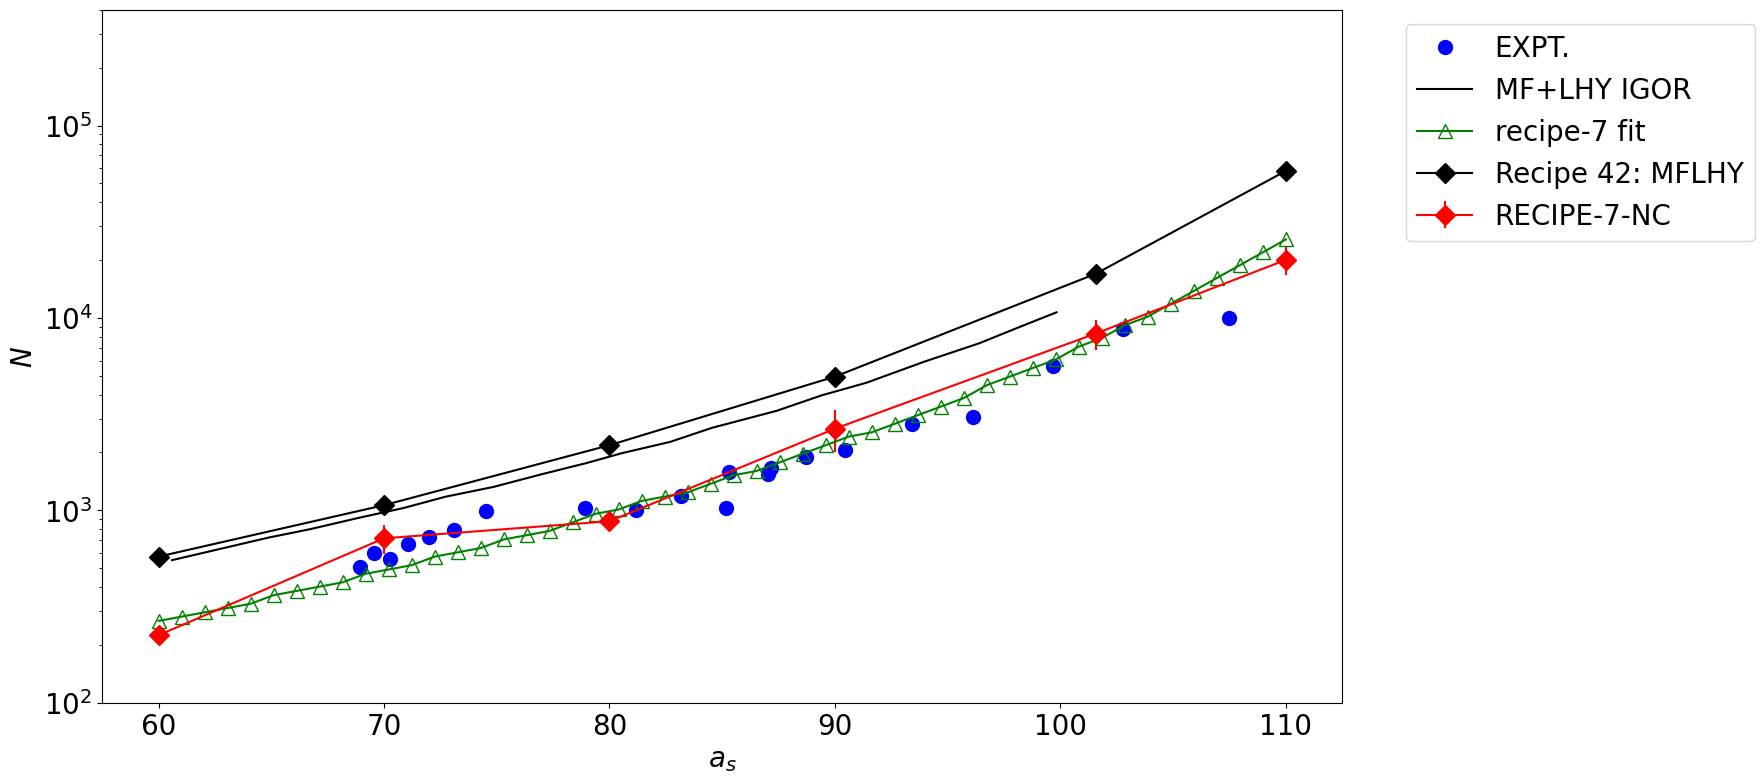

In [37]:

plt.figure(figsize=(16, 9))

def log_func_fit(x, a, b, c):
    return a*x**2 + b*x + c
def func_fit(x, a, b, c):
    return np.exp(log_func_fit(x, a, b, c))
data = np.loadtxt("./experimental-data/combined-critical-atom-number.dat")
sclen_expt = data[:,0]
nc_expt = data[:,1]
popt, pcov = curve_fit(f=log_func_fit, xdata=sclen_expt, ydata=np.log(nc_expt))

plt.plot(sclen_expt, nc_expt, label="EXPT.", ls='', marker='o', color='blue', markersize=10)


mf_data = np.loadtxt("./experimental-data/mean_field_IGOR.dat")
sclen_mf = mf_data[:,0]
nc_mf = mf_data[:,1]
plt.plot(sclen_mf, nc_mf, label="MF+LHY IGOR", color='black', markersize=10)

# load data from file ./results/critical-atom-numbers/recipe-7-nc/functionals_E_N_average_std.dat and plot it
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-7-NC", color='red', ls='-', marker='D', markersize=10)




# same, but for recipe 8
data = np.loadtxt("./results/critical-atom-numbers/recipe-8-nc/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
# plot the green error bars, but with the line, with non filled markers
# plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-8-NC", color='green', ls='-', marker='^', markersize=10, markerfacecolor='none')


plt.plot(a_s, n_c_best_possible_fit, label="recipe-7 fit", color='green', ls='-', marker='^', markersize=10, markerfacecolor='none')

# Open the output file for writing
# data = np.loadtxt("results/critical-atom-numbers/recipe-7-nc/functionals_E_N_2nd_approach.dat")
# # the header is as follows: a_s <n_c>  err(n_c)  <beta>  err(beta) <gamma>  \n"). Read the data and plot
# sclen = data[:,0]
# nc = data[:,1]
# nc_std = data[:,2]
# plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-7-NC-2ND-APPROACH", color='green', ls='-', marker='o', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 42: MFLHY", color='black', marker='D', ls='-', markersize=10)


plt.xlabel(r'$a_s$', fontsize=20)
plt.ylabel(r'$N$', fontsize=20)
plt.legend(loc = "best", bbox_to_anchor=(1.04, 1), fontsize=20)


plt.yscale('log')
plt.ylim(100, 400000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Save the figure into plots folder
plt.savefig(f"plots/critical-atom-number.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"plots/critical-atom-number.png", bbox_inches='tight', dpi=300)
